# Example

This notebook shows the same results than the one titled `04-Example`, but it does not include any code to create or solve the example, only to visualize the results. The problem is created and solved from command line, using:

```
snakemake -s Snakefile.data
snakemake -s Snakefile.example
```

## Preamble code

In [1]:
# Preliminary setup and imports

# For graphics and HTML tables
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline
from IPython.display import display, HTML

# Add to python path the folder where LLOVIA is located
import os,sys,inspect
currentdir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/solve"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/visualization"))


In [2]:
# Parameters to generate paper-ready graphics
sb_white=dict(matplotlib.style.library["seaborn-whitegrid"])
sb_paper=dict(matplotlib.style.library["seaborn-paper"])
my_settings = {
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": (3.5, 2.5),
    'grid.linestyle': '-',
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,
    "lines.markersize": 3,
    "lines.linewidth": 0.8,
    "text.usetex": False,   
    "font.family": "serif",
    "pgf.rcfonts": False,
    "font.serif": [],   
    "font.sans-serif": [],
    "font.monospace": [],
}
paper_style = {}
for x in [sb_white, sb_paper, my_settings]:
    paper_style.update(x)
    
# Parameters to generate larger graphics, more adequete for the notebook
notebook_style = {}
my_settings = {
   "figure.figsize": (7, 5)
}
for x in [dict(matplotlib.style.library["seaborn-darkgrid"]),
          dict(matplotlib.style.library["seaborn-notebook"])]:
    notebook_style.update(x)

In [3]:
from lloovia import (InstanceClass, Lloovia, LimitingSet, Problem, SolutionI, SolutionII)
from lloovia_plot import plot_solution_slots
import pandas as pd
from collections import OrderedDict

# Data for the problem

In [4]:
def prettify_names(instance_classes, amazon_or_azure=False):
    """Generate readable instance names from instance attributes"""
    import re
    colnames=[]
    regions = set()
    cont_regions = 0
    n_provider=""
    for col in instance_classes:
        if col.reserved:
            n_res = " [res]"
            n_zone = re.search(r'AZ(\d+)',col.cloud.name)
            if n_zone:
                n_zone = "-Z{}".format(n_zone.groups()[0])
            else:
                n_zone = ""
        else:
            n_res = " [dem]"
            n_zone = ""
        if "(" in col.cloud.name:
            m = re.search(r'(.*?) \((.*?)\)', col.cloud.name)
            n_region = "{}-{}".format(m.group(1), m.group(2))
            if amazon_or_azure:
                n_provider = "Amazon, "
        else:
            n_region = col.cloud.name
            if amazon_or_azure:
                n_provider = "Azure, "

        n_cloud = " ({}{}{})".format(n_provider, n_region, n_zone)
        name = "{}{}{}".format(col.name, n_cloud, n_res)
        colnames.append(name)
    return colnames

In [5]:
problem = Problem.load("../data/interim/example_problem.pickle")

In [6]:
# Display instances charactersitics
pd.DataFrame([x.__dict__ for x in problem.instances])[["cloud","reserved","name","price","performance"]]

,cloud,reserved,name,price,performance
0,Region1,False,small,0.050,5
1,Region1,False,large,0.110,10
2,Region2,False,small,0.052,5
3,Region2,False,large,0.120,10
4,Region2 Z1,True,small,0.038,5
5,Region2 Z1,True,large,0.090,10
6,Region2 Z2,True,small,0.038,5
7,Region2 Z2,True,large,0.090,10


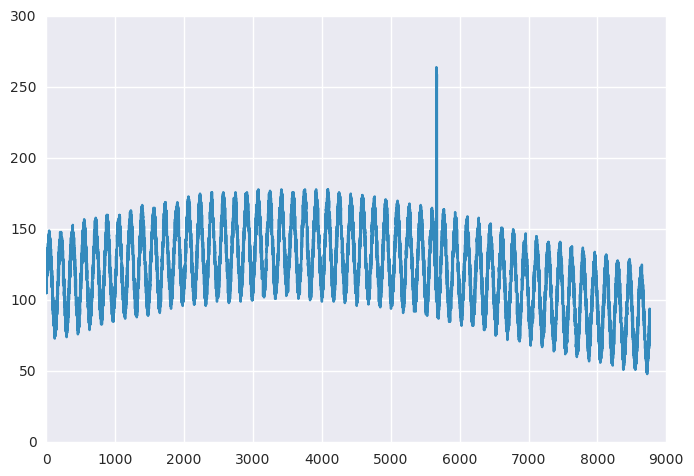

In [7]:
# Simple plot of the workload
with matplotlib.style.context(notebook_style):
    plt.plot(problem.workload)

# Solving, Phase I

## No binning (optimal solution)

In [8]:
phase_I_solution = SolutionI.load("../data/interim/example_phase_I.pickle")

Several statistics about the status (optimallity) of the solution, the time required to create and solve the problem, the parameters passed to the solver, and a copy of the problem, can be retrieved from `phase_I.solution`. See for example the solving stats:

In [9]:
phase_I_solution.solving_stats

SolvingStatsI(max_bins=None, workload=LlooviaHistogram(139 elements), frac_gap=None, max_seconds=None, creation_time=0.09594466001726687, solving_time=0.10779829998500645, status='optimal', lower_bound=None, optimal_cost=9015.216000000004)

The complete allocation for each load-level is also available as a pandas DataFrame, and from it several results can be obtained, such as the total cost of the proposed allocation, which has to be equal to the optimal cost found by the solver (see above)

In [10]:
print("Total cost: %f" % phase_I_solution.get_cost("total"))
print("Cost of reserved instances: %f" % phase_I_solution.get_cost("reserved"))
print("Cost of on-demand instances: %f" % phase_I_solution.get_cost("ondemand"))

Total cost: 9015.216000
Cost of reserved instances: 6990.480000
Cost of on-demand instances: 2024.736000


In [11]:
allocation = phase_I_solution.allocation
# Show part of the solution, for example, the optimal allocation for l=160
l=160
allocation.loc[l]

small_Region2 Z2_R     9.0
large_Region2 Z1_R     0.0
small_Region2 Z1_R    12.0
large_Region2 Z2_R     0.0
small_Region1         10.0
small_Region2          1.0
large_Region2          0.0
large_Region1          0.0
Name: 160.0, dtype: float64

In [12]:
# Define some colors for the following plots
import matplotlib.cm as cm
mycolors = [
    cm.Greens(0.6), cm.Greens(0.9), # Those are for reserved VMs in any zone
    cm.Blues(0.6), cm.Blues(0.9),   # Those are for on-demand VMs in Region1
    cm.Reds(0.6), cm.Reds(0.9),     # Those are for on-demand VMs in Region2
]

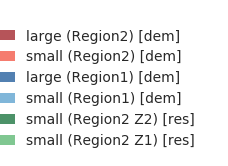

In [13]:
# Plot the legend (the same for all the plots to follow)
import matplotlib.patches as mpatches

# Create auxiliar plot to get the colors and labels for the legend
with matplotlib.style.context(notebook_style):
    aux = plot_solution_slots(allocation, linewidth=0, legend=False,  
                              amazon_or_azure=False, colors=mycolors)
    plt.close() # Close the plot to avoid displaying it

    # Draw a separate legend
    patches, labels = aux.get_legend_handles_labels()
    f = plt.figure(figsize=(1,1))
    ax = f.add_subplot(111)
    ax.set_axis_off()  #turn off the axis 
    ax.legend(reversed([mpatches.Rectangle((0, 0), 1, 1, fc=handle.get_color(),
                                                  linewidth=handle.get_linewidth(),
                                                  alpha=handle.get_alpha())
                               for handle in patches]) , reversed(labels))
    
    plt.gcf().savefig("../reports/figures/fig-007-legend.pgf", bbox_inches = 'tight')

In [14]:
# Obtain the histogram as dataframe, used in following plots
H = phase_I_solution.solving_stats.workload
dfh=pd.DataFrame(list(H.items()))
dfh.columns=["Load level", "Count"]
dfh = dfh.sort_values(by="Load level")
dfh = dfh.set_index("Load level")

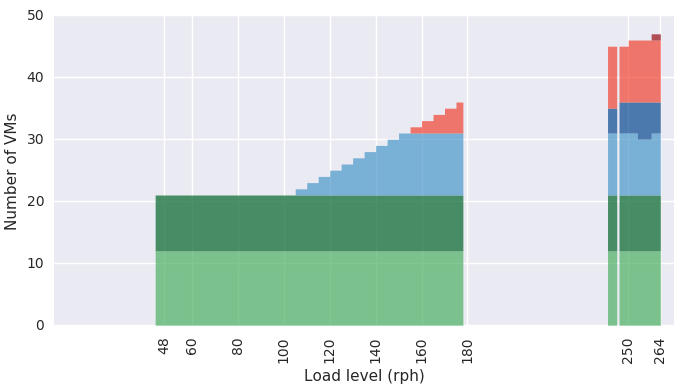

In [15]:
# Plot the allocation (using load levels as x-axis)

# First, fill with zero the load levels absent from the input histogram
all_levels = pd.DataFrame(list(range(int(dfh.index.max()))), columns=["Load level"])
all_levels = all_levels.set_index("Load level")
allocation.index.name="Load level"
all_levels = pd.concat([all_levels, allocation], axis=1).fillna(method="bfill", limit=3)

# Plot the result as a stacked area graph
with matplotlib.style.context(notebook_style):
    p = plot_solution_slots(all_levels, linewidth=0, 
                            #figsize=(3.3, 1.5), # Size for paper
                            figsize=(8,4),
                            legend=False,  amazon_or_azure=False, colors=mycolors)
    p.set_xlabel("Load level (rph)")
    p.set_ylabel("Number of VMs")
    p.set_xlim(0,270)

    # Select a subset of x-ticks to label
    ticks = [48] + list(range(60,185,20)) + [250, 264]
    p.set_xticks(ticks)
    p.set_xticklabels(ticks, rotation=90)
    plt.gcf().savefig("../reports/figures/fig-005-optimal-alloc-vs-load.pgf", bbox_inches = 'tight')

In [16]:
# Convert the solution from the load-level domain to the time-slot domain
import numpy as np
def load_levels_to_slots(load, allocation):
    bins = allocation.index
    q_index = np.digitize(load, bins, right=True)
    npsol = np.take(allocation.get_values(), q_index, axis=0)
    return pd.DataFrame(npsol, columns=allocation.columns)

allocation_t = load_levels_to_slots(problem.workload, allocation)

The allocation for Phase I can be expanded in time again, as shown in next plot, using for each time slot the optimal allocation given by the solution for the load level present in that time slot.

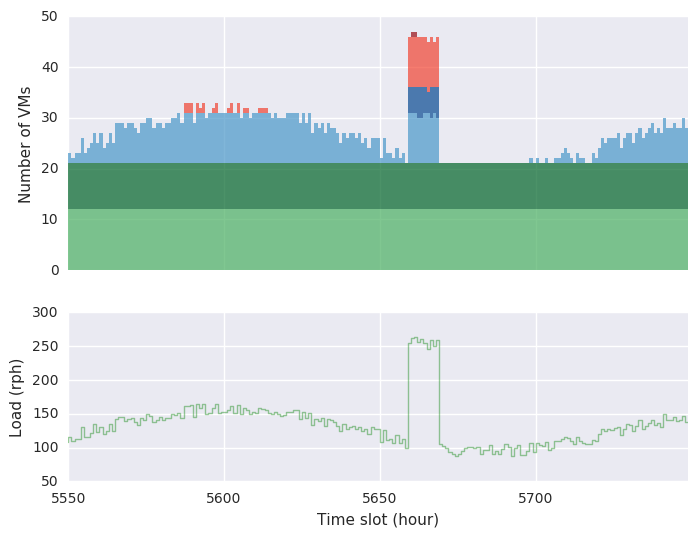

In [17]:
# Plot again the solution, but using time slots as x-axis
# Instead of plotting the whole year, we show only a region of interest 
# around the spike
zoom = (5550, 5750)  # xlimits to zoom in the auxiliar plot
xlim = zoom

with matplotlib.style.context(notebook_style):
    # Two subplots, one for the allocations, another for the workload
    f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 2]})

    # 1) Plot the allocations as stacked areas
    plot_solution_slots(allocation_t, ax = axarr[0], linewidth=0, colors=mycolors,
                       amazon_or_azure=False, 
                        # figsize=(3.3,2),   # Size for  paper
                        figsize=(8,6),
                       xlim = xlim, legend=False)
    axarr[0].set_ylabel("Number of VMs")

    # 2) Plot the workload as a stepwise function
    sli = slice(*xlim)
    r = range(*xlim)
    axarr[1].step(r, problem.workload[sli], alpha=0.4, color="green", linewidth=1)
    axarr[1].set_ylabel("Load (rph)")
    axarr[1].set_xlabel("Time slot (hour)")
    f.subplots_adjust(hspace=0.2)
    plt.gcf().savefig("../reports/figures/fig-006-optimal-alloc-vs-time.pgf", bbox_inches = 'tight')

## Binning (10 bins, 8 effective load levels)

In [18]:
phase_I_10_solution = SolutionI.load("../data/interim/example_phase_I_10bins.pickle")

The cost of this allocation is not optimal. It will be enhanced in Phase II.

In [19]:
allocation_10 = phase_I_10_solution.allocation
print("Cost of this allocation:", phase_I_10_solution.get_cost())

Cost of this allocation: 9718.572


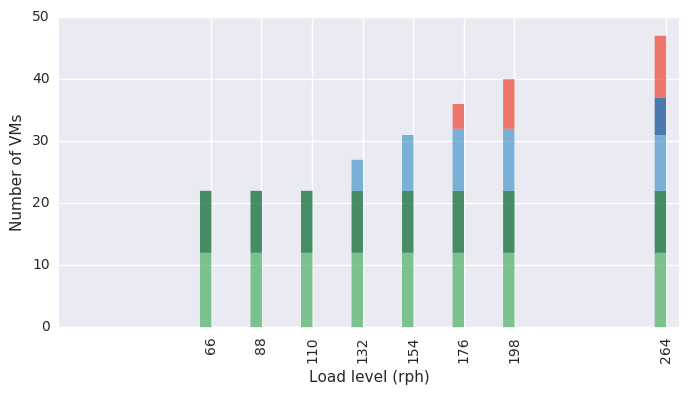

In [20]:
# Plot the solution with load-levels in x-axis
H10 = phase_I_10_solution.solving_stats.workload
dfh10=pd.DataFrame(list(H10.items()))
dfh10.columns=["Load level", "Count"]
dfh10 = dfh10.sort_values(by="Load level")
dfh10 = dfh10.set_index("Load level")

# First, fill with zeros the load-levels not present in the solution
all_levels = pd.DataFrame(list(range(int(dfh10.index.max()))), columns=["Load level"])
all_levels = all_levels.set_index("Load level")
allocation_10.index.name="Load level"
all_levels = pd.concat([all_levels, allocation_10], axis=1).fillna(method="bfill", limit=4)

# Plot this solution
with matplotlib.style.context(notebook_style):
    p = plot_solution_slots(all_levels,  linewidth=0, legend=False,
                            # figsize=(3.3, 1.6),   # Size for the paper version
                            figsize=(8,4),
                            amazon_or_azure=False, colors=mycolors)

    # Put labels only at xticks present in the solution
    ticks = [int(round(t)) for t in H10.keys()]
    p.set_xticks(ticks)
    p.set_xticklabels(ticks, rotation=90)
    p.set_xlabel("Load level (rph)")
    p.set_ylabel("Number of VMs")
    p.set_xlim(0,270)
    plt.show() 

The plot shows the solution for this case. In this solution, the optimal allocation is found only for a small subset of predicted workloads, which are the ones labeled in the x-axis (coincident with the ones in the histogram obtained with binning). 

In [21]:
# Convert the solution from the load-level domain to the time-slot domain
allocation_10_t = load_levels_to_slots(problem.workload, allocation_10)

To plot this solution on the time axis, as shown below, each load level is quantized to the closest above in the set of effective load levels produced by the binning. The lower part of that plot shows this quantization.

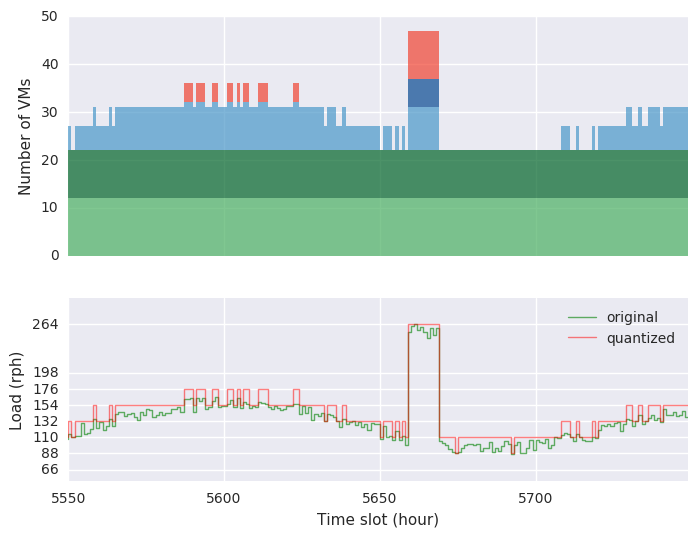

In [22]:
# Plot again the solution, but using time slots as x-axis
# Instead of plotting the whole year, we show only a region of interest 
# around the spike

xlim = zoom



# Plot the allocations
with matplotlib.style.context(notebook_style):
    # Two subplots, one for the allocation, another for the workload
    f, ax = plt.subplots(2, sharex=True, 
                         gridspec_kw = {'height_ratios':[3, 2.3]})
    plot_solution_slots(allocation_10_t, ax = ax[0], linewidth=0, 
                        colors=mycolors, amazon_or_azure=False, xlim = xlim, 
                        legend=False,
                        # figsize=(3.3,3),    # Size for the paper version
                        figsize=(8,6),
                         )
    ax[0].set_ylabel("Number of VMs")

    # Plot the workload, showing the quantization effect of binning
    r = range(*xlim)
    sli = slice(*xlim)
    ax[1].step(r, problem.workload[sli], label="original", color="green", 
               alpha=0.6, linewidth=1)

    # Quantize the load and plot it too
    bins = sorted(list(H10.keys()))
    load_q = np.take(bins, np.digitize(problem.workload, bins, right=True))
    ax[1].step(r, load_q[sli], alpha=0.5, color="red", label="quantized", 
               linewidth=1)

    # Label y-ticks in the load only for effective load levels
    ax[1].set_yticks(list(H10.keys()))
    ax[1].set_ylabel("Load (rph)")
    ax[1].set_xlabel("Time slot (hour)")
    ax[1].legend()
    f.subplots_adjust(hspace=0.2)
    plt.show()

# Solving, Phase II

In [23]:
phase_II_solution = SolutionII.load("../data/interim/example_phase_II_10bins.pickle")

It provides attributes and methods to obtain statistics, allocation, cost, etc. analogous of the ones in Phase I solution.

In [24]:
print(phase_II_solution)
print(phase_II_solution.solving_stats)

optimal solution with global ondemand cost 1708.3399999999833
SolvingStatsII(workload=array([ 105.,  120.,  114., ...,   86.,   94.,   85.]), default_frac_gap=None, default_max_seconds=None, global_creation_time=0.0658656416926533, global_solving_time=0.6891463726060465, global_status='optimal', global_cost=1708.3399999999833, individual_status=StatusList({'optimal', 'trivial'}))


In [25]:
print("Cost for the whole year:   %f" % phase_II_solution.get_cost())
print("Compare with optimal:      %f" % phase_I_solution.get_cost())
print("Compare with Phase I only: %f" % phase_I_10_solution.get_cost())

Cost for the whole year:   9031.700000
Compare with optimal:      9015.216000
Compare with Phase I only: 9718.572000


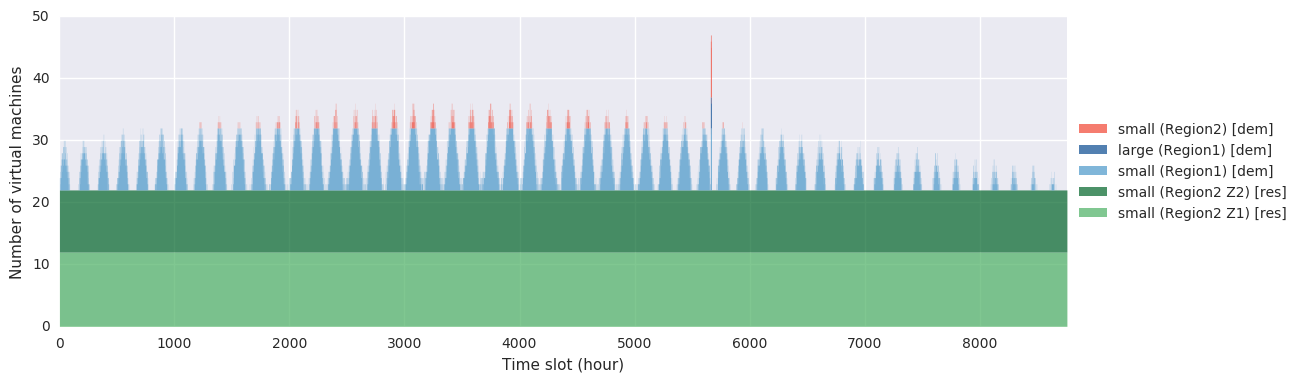

In [26]:
# Plot the optimal allocation for each time-slot for the whole year 
# (this plot was not shown in the paper)
with matplotlib.style.context(notebook_style):
    p = plot_solution_slots(phase_II_solution.get_allocation(), linewidth=0, colors=mycolors,
                       amazon_or_azure=False, figsize=(13,4),
                       pos_legend=("center left", (1,0.5)))
    p.set_xlabel("Time slot (hour)")

/home/jldiaz/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


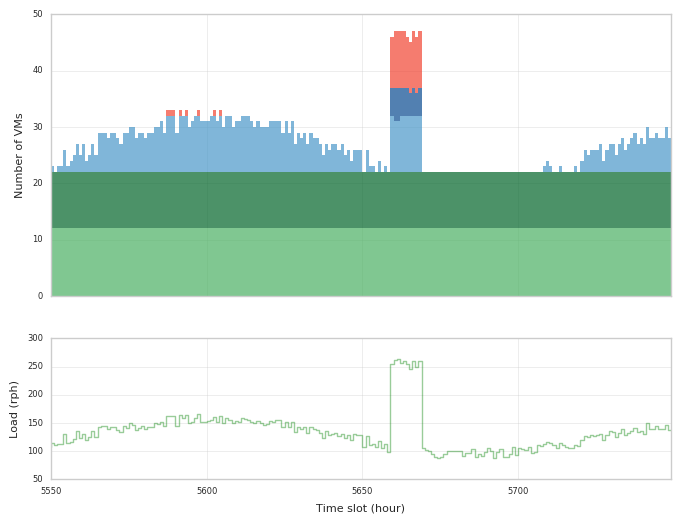

In [27]:
# Zoom around the spike (not shown in the paper)
xlim = zoom

with matplotlib.style.context(paper_style):
    # Two subplots, one for the allocation, another for the workload
    f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1.5]})

    # Plot the allocations
    plot_solution_slots(phase_II_solution.get_allocation(), ax = axarr[0], 
                        linewidth=0, colors=mycolors,
                        amazon_or_azure=False, figsize=(8,6),
                        xlim = xlim, legend=False)

    # Plot the workload
    sli = slice(*xlim)
    r = range(*xlim)
    axarr[1].step(r, phase_II_solution.solving_stats.workload[sli],
                  label="original", 
                  color="green", alpha=0.4, linewidth=1)
    axarr[1].set_ylabel("Load (rph)")
    axarr[0].set_ylabel("Number of VMs")
    axarr[1].set_xlabel("Time slot (hour)")
    f.subplots_adjust(hspace=0.2)
    plt.show()